In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import math 
import copy 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

In [2]:
#input file
input_data = 'clean_kaggle_data_2020.csv'
df = pd.read_csv(input_data)
#first row is question, remove
df = df.drop([0])
df

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,Q24_Encoded,Q24_buckets
1,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
2,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,"10,000-19,999"
3,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,"125,000-149,9991"
4,762,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,"70,000-79,999"
5,742,35-39,Man,United States of America,Doctoral degree,Research Scientist,1-2 years,NaN,R,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,"30,000-39,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,2104,35-39,Man,Malaysia,I prefer not to answer,Machine Learning Engineer,1-2 years,Python,NaN,NaN,...,NaN,TensorBoard,NaN,NaN,Trains,NaN,NaN,NaN,0.0,"0-9,999"
10726,5461,35-39,Man,Thailand,Bachelor’s degree,Other,10-20 years,NaN,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,"10,000-19,999"
10727,238,30-34,Man,Brazil,Master’s degree,Research Scientist,< 1 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"0-9,999"
10728,625,22-24,Man,India,Bachelor’s degree,Software Engineer,3-5 years,Python,NaN,SQL,...,NaN,TensorBoard,NaN,NaN,Trains,NaN,NaN,NaN,0.0,"0-9,999"


<AxesSubplot:>

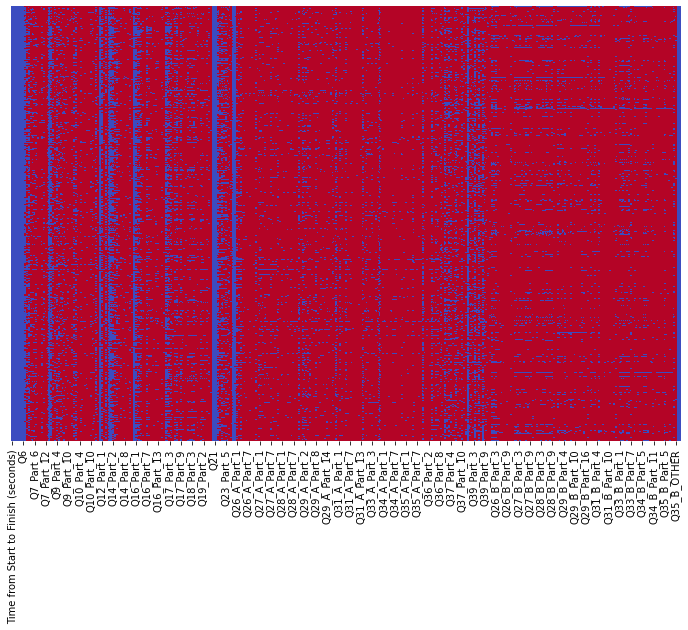

In [3]:
#Plot
fig, ax = plt.subplots(figsize = (12,8))
sns.heatmap(df.isnull(), cmap = 'coolwarm', yticklabels = False,cbar = False, ax=ax)

## 1. Data Cleaning 
As several several values are missing and some of the features are categorical, data cleaning is performed berfore implementation of algorithm. 

### 1.1 Missing Values

**Procedure** : Remove columns with at least 30% of missing entries. 

**Justication** : For the purpose of EDA and implementation, at least 5000 training samples is required, Since we are doing a 70:30 train test split, we need at least 7142 samples in total (67% of original data).To maintain enough samples for further model building, we need need to remove features that has more than 30% of missing values. 

**Result** : There are 20 columns remaining in the dataset. Columns related to Q7, Q9-Q10, Q12, Q14, Q16-Q19, Q23, Q26-Q37, Q39 are dropped. There is one column of Q7 is left. This column represent whether the respondent uses python. Majority of the columns dropped are from the second half of the questionaire. One reason is most of these questions are multiple choices (selct-all if applied). Removing features with low response rate helps reduce the time required for training the regression model, but it may also lower the training accuracy and prediction accuracy since many information are eliminated.


In [4]:
miss_30 = [] 
t30 = 0.3*df.shape[0]
for col in df.columns:
    n_nan = df[col].isnull().sum()
    if n_nan >= t30 :
        miss_30.append(col)
        df.drop([col], axis=1, inplace = True)
print("Number of remaining columns:", df.shape[1])
print('Number of columns deleted:', len(miss_30))
print("The following columns are dropped")
print ('\n'.join(miss_30))



Number of remaining columns: 20
Number of columns deleted: 337
The following columns are dropped
Q7_Part_2
Q7_Part_3
Q7_Part_4
Q7_Part_5
Q7_Part_6
Q7_Part_7
Q7_Part_8
Q7_Part_9
Q7_Part_10
Q7_Part_11
Q7_Part_12
Q7_OTHER
Q9_Part_1
Q9_Part_2
Q9_Part_3
Q9_Part_4
Q9_Part_5
Q9_Part_6
Q9_Part_7
Q9_Part_8
Q9_Part_9
Q9_Part_10
Q9_Part_11
Q9_OTHER
Q10_Part_1
Q10_Part_2
Q10_Part_3
Q10_Part_4
Q10_Part_5
Q10_Part_6
Q10_Part_7
Q10_Part_8
Q10_Part_9
Q10_Part_10
Q10_Part_11
Q10_Part_12
Q10_Part_13
Q10_OTHER
Q12_Part_1
Q12_Part_2
Q12_Part_3
Q12_OTHER
Q14_Part_1
Q14_Part_2
Q14_Part_3
Q14_Part_4
Q14_Part_5
Q14_Part_6
Q14_Part_7
Q14_Part_8
Q14_Part_9
Q14_Part_10
Q14_Part_11
Q14_OTHER
Q16_Part_1
Q16_Part_2
Q16_Part_3
Q16_Part_4
Q16_Part_5
Q16_Part_6
Q16_Part_7
Q16_Part_8
Q16_Part_9
Q16_Part_10
Q16_Part_11
Q16_Part_12
Q16_Part_13
Q16_Part_14
Q16_Part_15
Q16_OTHER
Q17_Part_1
Q17_Part_2
Q17_Part_3
Q17_Part_4
Q17_Part_5
Q17_Part_6
Q17_Part_7
Q17_Part_8
Q17_Part_9
Q17_Part_10
Q17_Part_11
Q17_OTHER
Q18_Part_1
Q1

**Procedure and Justification**: Remove columns that are irrelevant to analysis or modify or remove columns that have NaN value. 

1) Remove the first column and Q24. The first column simply represents the time it took for the respondent to complete the questionaire and it is irrelevant for our analysis. Q24 is encoded and bucketed and store in other column and for the purpose of our analysis, we will be working with the encoded version of this column, therefore we don't need this. 

2) Q7_Part_1: One of the choice of a multiple choice question: Which Programming language do you use on regular basis? This is column is Pyhon, any entry with value in this column represents that the respondent uses Python. We can modify this column into a binary question: Do you use Python on regular basis? 1 means the respondent uses Python and 0 otherwise. 

3) Q38 has 1253 NaN entries, replace NaN with 'Unknown'. Q38 contains more than 10% missing entries, replacing NaN with 'Unknown' helps preserving these entries and a certain degree of information provided by the feature

4) Q8, Q11, Q13, Q15, has the same number of missing value, it might be the same respondents that has NaN for these four column. We will drop any rows that has more than 4 NaN value and check if my assumption is true. If there are still NaN, reduce to drop any rows that has more than 3. 

5) Q25 has 159 missing value. That is around 1% of our dataset. It won't have to much impact if they are removed.

**Result**:  Q7_Part_1 are now replaced with 0,1. Q8, Q11, Q13, Q15 removed all NaN in total 561 row. When removing NaN entries for Q8, Q11, Q13, Q15, so of these entries also have NaN for column Q25. There are 134 missing values for Q25, we will remove all of these. All NaN value are dealt with. We have 16 feature columns and 2 target columns. 

In [5]:
#remove the first column, since its just time it took to do the survey, irrelevant for our implementaion 
df = df.drop(df.columns[0], axis=1)
df = df.drop ('Q24', axis =1)
df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q8,Q11,Q13,Q15,Q20,Q21,Q22,Q25,Q38,Q24_Encoded,Q24_buckets
1,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,Python,A personal computer or laptop,2-5 times,1-2 years,"10,000 or more employees",20+,"We have well established ML methods (i.e., mod...","$100,000 or more ($USD)","Business intelligence software (Salesforce, Ta...",10.0,"100,000-124,999"
2,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,R,A personal computer or laptop,Never,I do not use machine learning methods,"1000-9,999 employees",0,No (we do not use ML methods),$0 ($USD),"Basic statistical software (Microsoft Excel, G...",1.0,"10,000-19,999"
3,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,Python,"A cloud computing platform (AWS, Azure, GCP, h...",2-5 times,3-4 years,250-999 employees,5-9,"We have well established ML methods (i.e., mod...","$10,000-$99,999","Local development environments (RStudio, Jupyt...",11.0,"125,000-149,9991"
4,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,Python,"A cloud computing platform (AWS, Azure, GCP, h...",2-5 times,2-3 years,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...","$10,000-$99,999","Cloud-based data software & APIs (AWS, GCP, Az...",7.0,"70,000-79,999"
5,35-39,Man,United States of America,Doctoral degree,Research Scientist,1-2 years,NaN,R,A personal computer or laptop,Never,Under 1 year,0-49 employees,1-2,We use ML methods for generating insights (but...,$1-$99,"Local development environments (RStudio, Jupyt...",3.0,"30,000-39,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,35-39,Man,Malaysia,I prefer not to answer,Machine Learning Engineer,1-2 years,Python,C++,A personal computer or laptop,Never,1-2 years,0-49 employees,5-9,I do not know,$0 ($USD),"Basic statistical software (Microsoft Excel, G...",0.0,"0-9,999"
10726,35-39,Man,Thailand,Bachelor’s degree,Other,10-20 years,NaN,Python,A personal computer or laptop,Never,I do not use machine learning methods,250-999 employees,0,No (we do not use ML methods),$0 ($USD),"Local development environments (RStudio, Jupyt...",1.0,"10,000-19,999"
10727,30-34,Man,Brazil,Master’s degree,Research Scientist,< 1 years,Python,Python,A personal computer or laptop,Never,I do not use machine learning methods,0-49 employees,0,We are exploring ML methods (and may one day p...,$0 ($USD),NaN,0.0,"0-9,999"
10728,22-24,Man,India,Bachelor’s degree,Software Engineer,3-5 years,Python,Python,"A cloud computing platform (AWS, Azure, GCP, h...",More than 25 times,1-2 years,"10,000 or more employees",20+,"We recently started using ML methods (i.e., mo...",$0 ($USD),"Local development environments (RStudio, Jupyt...",0.0,"0-9,999"


In [6]:
#check which column still has NaN
for col in df.columns:
    n_nan = df[col].isnull().sum()
    if n_nan >0  :
        print(n_nan, col)

2009 Q7_Part_1
561 Q8
561 Q11
561 Q13
561 Q15
159 Q25
1253 Q38


In [7]:
#replace q7 multiple choice to 0 = dont know python, 1= know python
df['Q7_Part_1'] = df['Q7_Part_1'].fillna(0)
df['Q7_Part_1'] = df['Q7_Part_1'].replace('Python', 1 )
df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q8,Q11,Q13,Q15,Q20,Q21,Q22,Q25,Q38,Q24_Encoded,Q24_buckets
1,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,1,Python,A personal computer or laptop,2-5 times,1-2 years,"10,000 or more employees",20+,"We have well established ML methods (i.e., mod...","$100,000 or more ($USD)","Business intelligence software (Salesforce, Ta...",10.0,"100,000-124,999"
2,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,0,R,A personal computer or laptop,Never,I do not use machine learning methods,"1000-9,999 employees",0,No (we do not use ML methods),$0 ($USD),"Basic statistical software (Microsoft Excel, G...",1.0,"10,000-19,999"
3,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,1,Python,"A cloud computing platform (AWS, Azure, GCP, h...",2-5 times,3-4 years,250-999 employees,5-9,"We have well established ML methods (i.e., mod...","$10,000-$99,999","Local development environments (RStudio, Jupyt...",11.0,"125,000-149,9991"
4,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,1,Python,"A cloud computing platform (AWS, Azure, GCP, h...",2-5 times,2-3 years,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...","$10,000-$99,999","Cloud-based data software & APIs (AWS, GCP, Az...",7.0,"70,000-79,999"
5,35-39,Man,United States of America,Doctoral degree,Research Scientist,1-2 years,0,R,A personal computer or laptop,Never,Under 1 year,0-49 employees,1-2,We use ML methods for generating insights (but...,$1-$99,"Local development environments (RStudio, Jupyt...",3.0,"30,000-39,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,35-39,Man,Malaysia,I prefer not to answer,Machine Learning Engineer,1-2 years,1,C++,A personal computer or laptop,Never,1-2 years,0-49 employees,5-9,I do not know,$0 ($USD),"Basic statistical software (Microsoft Excel, G...",0.0,"0-9,999"
10726,35-39,Man,Thailand,Bachelor’s degree,Other,10-20 years,0,Python,A personal computer or laptop,Never,I do not use machine learning methods,250-999 employees,0,No (we do not use ML methods),$0 ($USD),"Local development environments (RStudio, Jupyt...",1.0,"10,000-19,999"
10727,30-34,Man,Brazil,Master’s degree,Research Scientist,< 1 years,1,Python,A personal computer or laptop,Never,I do not use machine learning methods,0-49 employees,0,We are exploring ML methods (and may one day p...,$0 ($USD),NaN,0.0,"0-9,999"
10728,22-24,Man,India,Bachelor’s degree,Software Engineer,3-5 years,1,Python,"A cloud computing platform (AWS, Azure, GCP, h...",More than 25 times,1-2 years,"10,000 or more employees",20+,"We recently started using ML methods (i.e., mo...",$0 ($USD),"Local development environments (RStudio, Jupyt...",0.0,"0-9,999"


In [8]:
#replace with unknown 
df['Q38'] = df['Q38'].fillna('Unknown')

In [9]:
#eliminate all rows with 4 nan
df = df.dropna(thresh = 15)
print(df.shape)
#check which row still has NaN
for col in df.columns:
    n_nan = df[col].isnull().sum()
    if n_nan >0  :
        print(n_nan, col)

(10168, 18)
134 Q25


In [10]:
#eliminate all rows with 3 nan
df = df.dropna(thresh = 15)
print(df.shape)
#check which row still has NaN
for col in df.columns:
    n_nan = df[col].isnull().sum()
    if n_nan >0  :
        print(n_nan, col)

(10168, 18)
134 Q25


In [11]:
#Q25 money spent of ML service 
df = df.dropna()
df.shape

(10034, 18)

In [12]:
#check which row still has NaN
for col in df.columns:
    n_nan = df[col].isnull().sum()
    if n_nan >0  :
        print(n_nan, col)

**Procedure:** Rename column name based on orginal questionaire. 

In [13]:
#rename column names
Salary = copy.deepcopy(df)
Salary.columns =['Age', 'Gender','Country', 'Education', 'Role', 'Programming_Experience', 'Python',
                 'Recommend_Language', 'Computing_Platform','TPU_Usage','ML_Years','Company_Size', 'Company_DS_Team',
                 'ML_Methods', 'ML_Cost','Primary_Tool', 'Salary_Encoded', 'Salary_Buckets'] 
Salary.head()

,Age,Gender,Country,Education,Role,Programming_Experience,Python,Recommend_Language,Computing_Platform,TPU_Usage,ML_Years,Company_Size,Company_DS_Team,ML_Methods,ML_Cost,Primary_Tool,Salary_Encoded,Salary_Buckets
1,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,1,Python,A personal computer or laptop,2-5 times,1-2 years,"10,000 or more employees",20+,"We have well established ML methods (i.e., mod...","$100,000 or more ($USD)","Business intelligence software (Salesforce, Ta...",10.0,"100,000-124,999"
2,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,0,R,A personal computer or laptop,Never,I do not use machine learning methods,"1000-9,999 employees",0,No (we do not use ML methods),$0 ($USD),"Basic statistical software (Microsoft Excel, G...",1.0,"10,000-19,999"
3,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,1,Python,"A cloud computing platform (AWS, Azure, GCP, h...",2-5 times,3-4 years,250-999 employees,5-9,"We have well established ML methods (i.e., mod...","$10,000-$99,999","Local development environments (RStudio, Jupyt...",11.0,"125,000-149,9991"
4,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,1,Python,"A cloud computing platform (AWS, Azure, GCP, h...",2-5 times,2-3 years,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...","$10,000-$99,999","Cloud-based data software & APIs (AWS, GCP, Az...",7.0,"70,000-79,999"
5,35-39,Man,United States of America,Doctoral degree,Research Scientist,1-2 years,0,R,A personal computer or laptop,Never,Under 1 year,0-49 employees,1-2,We use ML methods for generating insights (but...,$1-$99,"Local development environments (RStudio, Jupyt...",3.0,"30,000-39,999"


### 1.2 Encoding Categorical Data 
Convert categorical data into numerical data by encoding so they can be use as input for prediction model. 

**Prodcedure:** One hot encoding algorithm will be use to covert categorical data into numerical data. Salary has already been encoded, 'Salary_Encoded' and 'Salary_buckets' are excluded from the conversion. The get_dummiers() function will convert each class into one binary column with 0,1 indicators. 

**Justicafication:** One hot encoding avoids the assumption that there are ordered relationship between each categorical data, it is advantage when it comes to overfitting. 

**Results**: 18 columns of data are expanded to in total 162 columns. 

In [14]:
ec_col = ['Age', 'Gender','Country', 'Education', 'Role', 'Programming_Experience', 'Python',
                 'Recommend_Language', 'Computing_Platform','TPU_Usage','ML_Years','Company_Size', 'Company_DS_Team',
                 'ML_Methods', 'ML_Cost','Primary_Tool',]
Salary_EC = pd.get_dummies(Salary, columns = ec_col, prefix = ec_col)
Salary_EC.head()

,Salary_Encoded,Salary_Buckets,Age_18-21,Age_22-24,Age_25-29,Age_30-34,Age_35-39,Age_40-44,Age_45-49,Age_50-54,...,"ML_Cost_$100,000 or more ($USD)",ML_Cost_$100-$999,"ML_Cost_$1000-$9,999","Primary_Tool_Advanced statistical software (SPSS, SAS, etc.)","Primary_Tool_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Primary_Tool_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Primary_Tool_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Primary_Tool_Local development environments (RStudio, JupyterLab, etc.)",Primary_Tool_Other,Primary_Tool_Unknown
1,10.0,"100,000-124,999",0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,1.0,"10,000-19,999",0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,11.0,"125,000-149,9991",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,7.0,"70,000-79,999",0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,3.0,"30,000-39,999",0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


**Procedure:** Manual encoding for the following features:

1) Age

2) ML_Years

3) Programming_Experience

4) TPU_Usage

5) ML_Cost

6) Education

7) Company_Size

8) Company_DS_Team (size)

Encode the remaining with LabelEncoder(). Salary_Buckets will be removed. We will also reset the row index. 

**Justification:** Too many features when encode using One hot encoding. If we use LabelEncoder() function, it will remain the same amount of columns. Even though it labels in ascending order for both alphabet and numbers, it will mess up numerical range numbers. For example, 10-15 years is label before 3-5 years. The ordered relation in these data must be conserved since we are doing an ordinal logistic regression model. Features with ordered relationship need to be mannually labeled. The gender column is also manually label simply for interpretation convenience. The Salary_Buckets column will be removed since we will only keep encoded data for analysis. 

**Result:** Total 16 encoded feature columns and 1 encoded target column. 

In [15]:
def encoder0 (value):  #gender
    mapdict = {'Man':0 ,'Woman': 1 ,'Nonbinary':2, 'Prefer not to say':3, 'Prefer to self-describe':4}
    
    return mapdict[value]

def encoder1 (value):  #ML_years
    mapdict = {'I do not use machine learning methods':0, 'Under 1 year': 1, '1-2 years': 1.5, '2-3 years': 2.5, '3-4 years': 3.5, 
               '4-5 years': 4.5, '5-10 years': 7.5,  '10-20 years': 15,  '20 or more years': 20}
    return mapdict[value]

def encoder2 (value):  #Programming_Experience 
    mapdict = {'< 1 years': 0, '1-2 years': 1.5,  '3-5 years': 4, '5-10 years': 7.5, '10-20 years': 15, '20+ years': 20}
    return mapdict[value]

def encoder3 (value):    #TPU
    mapdict = { 'Never':0, 'Once':1 ,'2-5 times':3.5, '6-25 times':15, 'More than 25 times':25}
    return mapdict[value]
 
def encoder4 (value):    #ML_Cost
    mapdict = {'$0 ($USD)': 0, '$1-$99': 1, '$100-$999': 2, '$1000-$9,999': 3, '$10,000-$99,999': 4,
                '$100,000 or more ($USD)': 5}
    return mapdict[value]

def encoder5 (value):   #Education 
    mapdict = {'I prefer not to answer': 0, 'No formal education past high school': 1, 
               'Some college/university study without earning a bachelor’s degree': 2,
               'Bachelor’s degree':3,'Professional degree':4,
               'Master’s degree':5, 'Doctoral degree':6}
    return mapdict[value]

def encoder6 (value):   # comp size 
    mapdict = {'0-49 employees': 0, '50-249 employees':1, '250-999 employees':2 ,
       '1000-9,999 employees':3,'10,000 or more employees':4}
    return mapdict[value]

def encoder7 (value):  # company data science team size
    mapdict = {'0':0, '1-2':1,'3-4':2, '5-9':3, '10-14':4, '15-19':5, '20+':6}
    return mapdict[value]

In [16]:
plt.figure(figsize=(15,15))
labelencoder = LabelEncoder()

Salary_E = Salary.copy()
Salary_E.drop(['Salary_Buckets'], axis=1, inplace=True)

for col in Salary_E.columns:
    Salary_E[col] = labelencoder.fit_transform(Salary_E[col])

Salary_E['Gender'] = Salary['Gender'].apply(encoder0)
Salary_E['ML_Years'] = Salary['ML_Years'].apply(encoder1)
Salary_E['Programming_Experience'] = Salary['Programming_Experience'].apply(encoder2)
Salary_E['TPU_Usage'] = Salary['TPU_Usage'].apply(encoder3)
Salary_E['ML_Cost'] = Salary['ML_Cost'].apply(encoder4)
Salary_E['Education'] = Salary['Education'].apply(encoder5)
Salary_E['Company_Size'] = Salary['Company_Size'].apply(encoder6)
Salary_E['Company_DS_Team'] = Salary['Company_DS_Team'].apply(encoder7)

Salary_E.head()

,Age,Gender,Country,Education,Role,Programming_Experience,Python,Recommend_Language,Computing_Platform,TPU_Usage,ML_Years,Company_Size,Company_DS_Team,ML_Methods,ML_Cost,Primary_Tool,Salary_Encoded
1,3,0,53,5,3,7.5,1,9,2,3.5,1.5,4,6,3,5,2,10
2,4,0,0,3,9,15.0,0,10,2,0.0,0.0,3,0,1,0,1,1
3,3,0,53,5,4,7.5,1,9,0,3.5,3.5,2,3,3,4,4,11
4,4,0,12,6,4,7.5,1,9,0,3.5,2.5,3,6,3,4,3,7
5,4,0,53,6,8,1.5,0,10,2,0.0,1.0,0,1,5,1,4,3


<Figure size 1080x1080 with 0 Axes>

In [17]:
Salary_E = Salary_E.reset_index(drop=True)
Salary_E

,Age,Gender,Country,Education,Role,Programming_Experience,Python,Recommend_Language,Computing_Platform,TPU_Usage,ML_Years,Company_Size,Company_DS_Team,ML_Methods,ML_Cost,Primary_Tool,Salary_Encoded
0,3,0,53,5,3,7.5,1,9,2,3.5,1.5,4,6,3,5,2,10
1,4,0,0,3,9,15.0,0,10,2,0.0,0.0,3,0,1,0,1,1
2,3,0,53,5,4,7.5,1,9,0,3.5,3.5,2,3,3,4,4,11
3,4,0,12,6,4,7.5,1,9,0,3.5,2.5,3,6,3,4,3,7
4,4,0,53,6,8,1.5,0,10,2,0.0,1.0,0,1,5,1,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10029,4,0,23,0,5,1.5,1,2,2,0.0,1.5,0,3,0,0,1,0
10030,4,0,47,3,6,15.0,0,9,2,0.0,0.0,2,0,1,0,4,1
10031,3,0,5,5,8,0.0,1,9,2,0.0,0.0,0,0,2,0,6,0
10032,1,0,15,3,9,4.0,1,9,0,25.0,1.5,4,6,4,0,4,0


## 2. Exploratory Data Analysis 
### 2.1 Trend in Data


Text(0.5, 1.0, 'Figure 1.Salary Distribution')

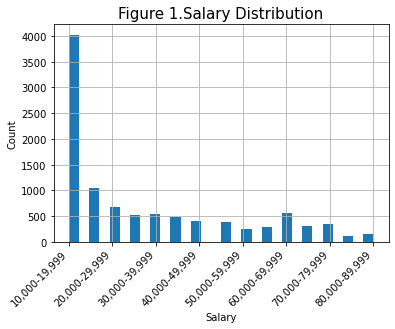

In [18]:
fig_0 = Salary['Salary_Encoded'].hist(bins = 30)
xlabels ='0-9,999', '20,000-29,999','40,000-49,999', '60,000-69,999', '80,000-89,999',
         '100,000-124,999','150,000-199,999','>250,000']
fig_0.set_xticklabels(xlabels, rotation = 45, ha='right')
plt.xlabel('Salary', size = 10)
plt.ylabel('Count', size =10)
plt.title('Figure 1.Salary Distribution', size =15)

In [19]:
print(Salary['Salary_Encoded'].value_counts())

0.0     4029
1.0     1037
2.0      675
10.0     549
4.0      533
3.0      512
5.0      488
6.0      393
7.0      378
12.0     340
11.0     310
9.0      277
8.0      254
14.0     146
13.0     113
Name: Salary_Encoded, dtype: int64


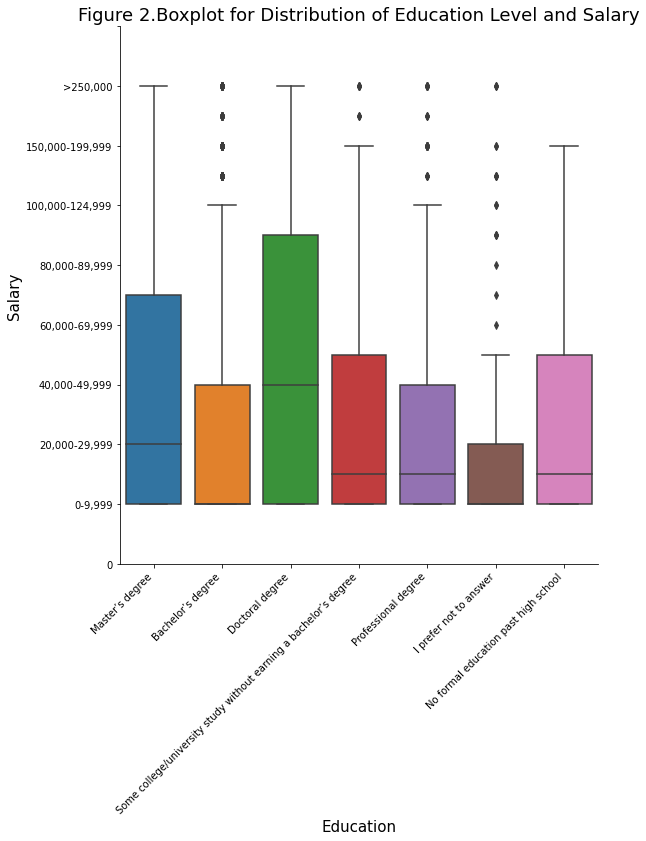

In [20]:
fig_1 = sns.catplot(x='Education', y='Salary_Encoded', kind = 'box', height=8, data = Salary)
fig_1.set_xticklabels(rotation = 45, ha='right'); 
ylabels =['0', '0-9,999', '20,000-29,999','40,000-49,999', '60,000-69,999', '80,000-89,999',
         '100,000-124,999','150,000-199,999','>250,000', ' ']
fig_1.set_yticklabels(ylabels)
plt.xlabel('Education', size = 15)
plt.ylabel('Salary', size = 15)
plt.title('Figure 2.Boxplot for Distribution of Education Level and Salary', size= 18);

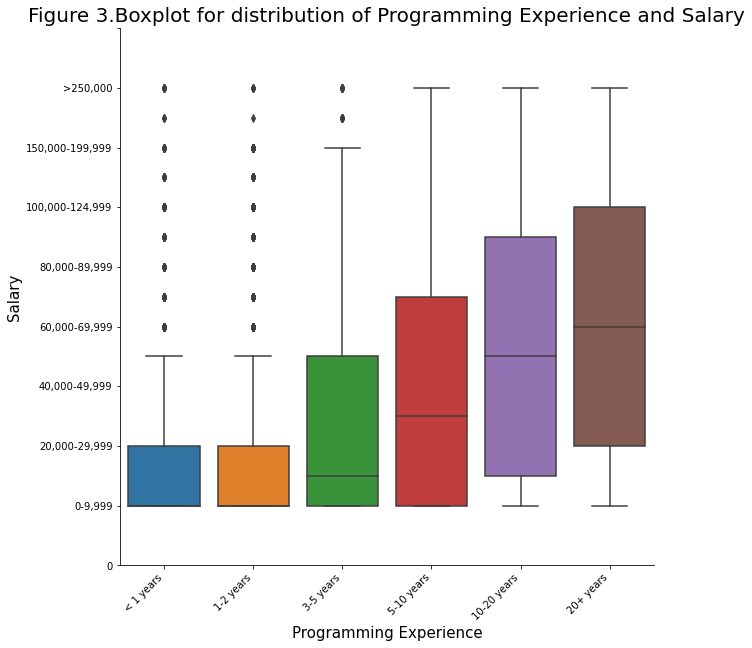

In [21]:
order =['< 1 years', '1-2 years', '3-5 years', '5-10 years', '10-20 years', '20+ years']
fig_3 = sns.catplot(x='Programming_Experience', y='Salary_Encoded', kind = 'box', height=8, data = Salary, order = order)
fig_3.set_xticklabels(rotation = 45, ha='right'); 
ylabels =['0', '0-9,999', '20,000-29,999','40,000-49,999', '60,000-69,999', '80,000-89,999',
         '100,000-124,999','150,000-199,999','>250,000', ' ']
fig_3.set_yticklabels(ylabels)
plt.xlabel('Programming Experience', size = 15)
plt.ylabel('Salary', size = 15)
plt.title('Figure 3.Boxplot for distribution of Programming Experience and Salary', size= 20);

### 2.2 Visualize the Order of Feature Importance

**Procedure:** Use the seaborn library to construct a heatmap based on the correlation between each feature and salary. 

**Justification:** To visualize the importance of feature related to the target, it is necessary construct a correlation plot. The Pearson correlation method. A Pearson correaltion coefficient is between -1 and 1 that indicates the extent to which two variables are linearly related. Negative coefficient represents negative correlation. Higher magitude of number (large |coeff|) represents stronger correlation. 


**Result:**

##### 5 Most Correlated Features with Salary :

1) Programming Experience (p = 0.39)

2) Age (p = 0.37)

3) Country (p= 0.37)

4) ML_Cost (p = 0.36) 

5) ML experience (ML_Years) (p = 0.33)

#####  5 Least Correlated Features 

1) Role (p = -0.0077) 

2) Primary Tool (p = 0.013)

3) TPU Usage (p = 0.018)

4) Python (p = -0.035)

5) Gender (p = -0.038)

|Most Correlated|Least Correlated|
|---------------|----------------|
|Programming Experience (p = 0.39)|Role (p = -0.0077)|
|Age (p = 0.37)|Primary Tool (p = 0.013)|
|Country (p= 0.37)|TPU Usage (p = 0.018)|
|ML_Cost (p = 0.36)|Python (p = -0.035)| 
|ML_Years (p = 0.33)|Gender (p = -0.038)|

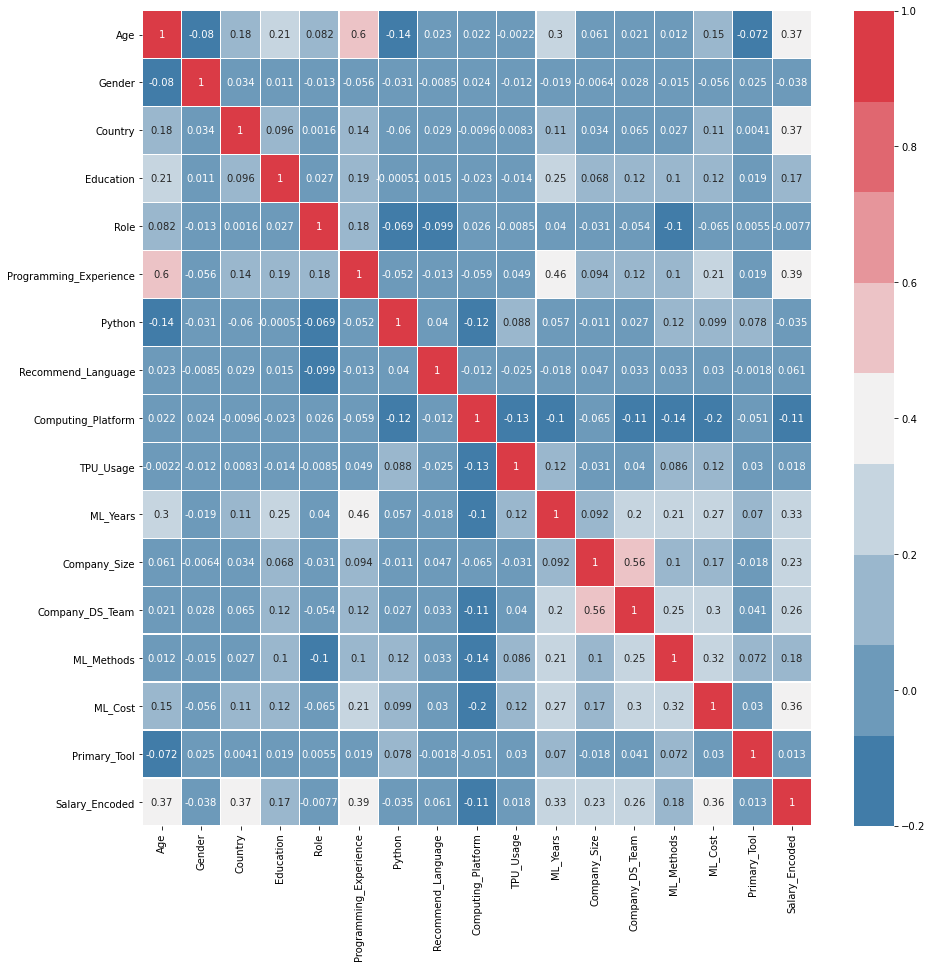

In [22]:
# correlation map
plt.figure(figsize=(15,15))
cmap = sns.diverging_palette(240, 10, n=9)
fig_3 = sns.heatmap(Salary_E.corr(method = 'pearson'), annot = True, cmap = cmap, linewidths = 0.2)

## 3. Feature Selection

Feature engineering is a process of using domain knowledge of the data to create features that make machine learning algorithms work. If feature engineering is done properly, it will increase the predictive power of machine learning algorithms by creating raw data that help facilitate the machine learning process. However if feature engineering fails to translate the crucial information in the data, it will aggravate the performance of the model. In this section, different feature engineering and selection algorithms are applied to explore the importance of each features and their correlation with the target variable. Feature selection not only speed up the algoritm but also eliminate some unnecesary noices of the data. 

#### 3.1 Lasso Regression (L1 Regularized Regression) Method

Regularization is a technique used to reduce the freedom of the model by adding penalty to different parameters of the model. For regularized regression, the penalty is applied over the coefficients that multiply each of the predictors. The Lasso (L1) regularized regression has the property that is able to shrink some of the coeeficients to zero such that certain features are removed from the model, therefore this is a suitable algorithm for feature selection. A threshold can also be added. If the feature has a non-zero but smaller than threshold coefficient, it will also be removed from the model due to insignificatn relationship with the output. 

**Procedure:** Apply Lasso regression with different threshold (0.05, 0.5). 

**Result:**  With a small threshold of 0.05, no features are eliminated which suggests that all features contain some extent of information for the prediction. With higher threshold 0.5, 5 features are removed. 

5 Worst Not Selected: 

1) TPU_Usage

2) Primary_Tool

3) Country

4) Programming_Experience 

5) ML_Years

Compared with the Peason correlation heatmap from 2.2, only two removed features matched; TPU_Usage and Primary_Tool. The other three removed features are actually 3 of the most correlated features in 2.2. This is normal because the mathematical algorithm used is different. We will also used other algorithm to perform feature selection and choose the one that shows up the most. 

In [23]:
S1 = copy.deepcopy(Salary_E)
y = S1['Salary_Encoded']
S1.drop(['Salary_Encoded'], axis =1, inplace = True )
X =S1 

#Split Train test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0, shuffle = True )
# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)

sel_ = SelectFromModel(LogisticRegression(solver = 'liblinear', C=1, penalty = 'l1', multi_class = 'auto'), threshold = 0.05)
sel_.fit(X_train, y_train)
sel_.get_support()
selected = X.columns[(sel_.get_support())]
print('selected features for threshold 0.05: {}'.format(np.sort(selected)))

sel_ = SelectFromModel(LogisticRegression(solver = 'liblinear', C=1, penalty = 'l1', multi_class = 'auto'), threshold = 0.5)
sel_.fit(X_train, y_train)
sel_.get_support()
selected = X.columns[(sel_.get_support())]
print('\nselected features for threshold 0.5: {}'.format(np.sort(selected)))
coln = S1.columns 
def disjoint(e,f):
    return list(set(e).symmetric_difference(set(f)))

print('\nFeature not selected for threshold = 0.5  :',disjoint(coln,np.sort(selected)))

selected features for threshold 0.05: ['Age' 'Company_DS_Team' 'Company_Size' 'Computing_Platform' 'Country'
 'Education' 'Gender' 'ML_Cost' 'ML_Methods' 'ML_Years' 'Primary_Tool'
 'Programming_Experience' 'Python' 'Recommend_Language' 'Role' 'TPU_Usage']

selected features for threshold 0.5: ['Age' 'Company_DS_Team' 'Company_Size' 'Computing_Platform' 'Education'
 'Gender' 'ML_Cost' 'ML_Methods' 'Python' 'Recommend_Language' 'Role']

Feature not selected for threshold = 0.5  : ['Country', 'TPU_Usage', 'Programming_Experience', 'ML_Years', 'Primary_Tool']


**3.2 Chi-Sqaure Test**

**Procedure:** perform chi-square test on all features. 

**Justification:** A chi-squre test can used to test the independence of two variables. A large chi-square value suggest that the feature is more dependent on the target whereas a small chi-square value suggest independence. 

**Result:**

Most Independent Features: 

1) Python

2) Primary_Tool

3) Recommended_Language

4) Role

5) Gender

Compare with Pearson correlation, most feature matched except for "Recommended_Language". Compared with Lasso regression, only the 'Primary_Tool' feature matched.  

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
Selected_F =np.empty((0,2))
for i in range(len(coln)):
    score = float(fs.scores_[i])
    Selected_F = np.append(Selected_F, np.array([[coln[i],score]]), axis=0)
#sorted(Selected_F,key=lambda x: x[1])
Selected_F

array([['Age', '1490.696976477434'],
       ['Gender', '49.56594858851041'],
       ['Country', '10697.366962299315'],
       ['Education', '98.41361864556478'],
       ['Role', '36.75138145946868'],
       ['Programming_Experience', '6338.401542154412'],
       ['Python', '4.440839909455654'],
       ['Recommend_Language', '14.30558942428198'],
       ['Computing_Platform', '45.273988594023166'],
       ['TPU_Usage', '433.95247442502955'],
       ['ML_Years', '3403.222002789235'],
       ['Company_Size', '727.9689646669831'],
       ['Company_DS_Team', '896.6203046668267'],
       ['ML_Methods', '265.32784762876275'],
       ['ML_Cost', '1443.0353318275204'],
       ['Primary_Tool', '12.665787565335417']], dtype='<U32')

#### 3.3 Recursive Feature Elimination (RFE) 

**Procedure:** We want to eliminate the worst 5 features, therefore the number of feature we want to keep is 11. 

**Justification:** RFE is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the coef_ or feature_importances_ model attributes and by recursively eliminating a small amount of feature per loop. The RFE method attempts to eliminate dependencies and collinearity that may exist in the model. 

**Result:** 

5 Worst Features: 

1) TPU_Usage

2) Primary_Tool

3) Gender 

4) Computing_Platform 

5) Python 

Compared with Pearson correlation, most matched except "Computing_Platform". Compared with Lasso regression, only TPU_Usage and Primary_Tool matched. Compared with chi-square test, all matched except for Computing_Platform. 


In [25]:
from sklearn.feature_selection import RFE 
SRFE = copy.deepcopy(Salary_E)
y = SRFE['Salary_Encoded']
SRFE.drop(['Salary_Encoded'], axis=1, inplace = True)
X = SRFE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0, shuffle=True)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)

model = LogisticRegression()
rfe = RFE(model,11)
fit = rfe.fit(X_train, y_train)
print("Selected Features: %s" % (X.columns[(fit.support_)]))

print('Feature not selected :',disjoint(coln,X.columns[(fit.support_)]))


Selected Features: Index(['Age', 'Country', 'Education', 'Role', 'Programming_Experience',
       'Recommend_Language', 'ML_Years', 'Company_Size', 'Company_DS_Team',
       'ML_Methods', 'ML_Cost'],
      dtype='object')
Feature not selected : ['TPU_Usage', 'Gender', 'Python', 'Computing_Platform', 'Primary_Tool']


#### 3.4 Feature Selection

We want to remove 5 least correlated features from out data set. Combining the result of all analysis and the correlation plot, we want to pick the features that showed up the most. The following five features are selected. 

1) TPU_Usage

2) Primary_Tool

3) Gender 

4) Role

5) Python 

Selected_Features with no obvious ordered relationship between inputs will be encoded using One-hot encoding with get_dummies() function. The final dataset has in total 10034 entries with 87 columns including the target variable. 

In [26]:
S_Selected = copy.deepcopy(Salary_E)
drop = ['TPU_Usage', 'Primary_Tool', 'Python', 'Gender', 'Role']
for col in drop:
    S_Selected. drop([col], axis = 1, inplace=True)

dummy_col = ['Country', 'Recommend_Language', 'Computing_Platform', 'ML_Methods' ]
S_Selected = pd.get_dummies(S_Selected, columns = dummy_col, prefix = dummy_col)
print(S_Selected.shape)
S_Selected.head()

(10034, 87)


,Age,Education,Programming_Experience,ML_Years,Company_Size,Company_DS_Team,ML_Cost,Salary_Encoded,Country_0,Country_1,...,Computing_Platform_1,Computing_Platform_2,Computing_Platform_3,Computing_Platform_4,ML_Methods_0,ML_Methods_1,ML_Methods_2,ML_Methods_3,ML_Methods_4,ML_Methods_5
0,3,5,7.5,1.5,4,6,5,10,0,0,...,0,1,0,0,0,0,0,1,0,0
1,4,3,15.0,0.0,3,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,0
2,3,5,7.5,3.5,2,3,4,11,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,6,7.5,2.5,3,6,4,7,0,0,...,0,0,0,0,0,0,0,1,0,0
4,4,6,1.5,1.0,0,1,1,3,0,0,...,0,1,0,0,0,0,0,0,0,1


## 4.0 Model Implementation and Hyperparameter Tuning

**Procedure** : Implement Ordinal Logistic Regression algorithm on training set using 10-fold cross-validation to obtain average model accuracy,bias, and variance of the model predictions. Evaluate accuracy across folds. Treat value of hyperparameters as new model, choose the best model based on the bias-variance trade-off theory. 


In [27]:
def bias(y_predict,y):
    y_predict = np.array(y_predict)
    y = np.array(y)
    return np.mean(np.power((y_predict-y),2))

def variance(y_predict):
    y_predict = np.array(y_predict)
    return np.var(y_predict)

### 4.1 Ordinal Logistic Function

**Model Logic:**
The ordinal logistic regression model implemented in this section is modified from the sklearn.LinearModel.LogisticRegression() based on the 'Ordinary Multi-class Classification algorithm'diagram shown in Lecture 5. The concept is quite similar to the OVR algorithm. The basic idea is breaking down a multi-class problem into multiple binary class problem. If we have n classes (A, B, D, etc) for out target variable, we define n-1 binary classification problem that caculates the probability of  a data point in Class 0 or Class 1, where for problem i, the probability of Class 0 represents the probability of a data point in Class A to Class i and the probability of Class 1 represents the probability of a data point in Class i+1 to Class n. 

The data has in total 15 salary buckets, therefore we need to define 14 binary logistic model. Since we are trainging 14 models, the target variable must be encoded differently for each binary model.. For example, for the first model mm0, Class 0 is in Class 0 and all other classes are considered as Class 1. For mm1, Class 0 and Class 1 are considered Class 0 and all other classes are considered as Class 1 and so on.  The encoded target are stored as y0, y1, and etc. Then the models are trained using 10 fold cross-validation. Instead of making prediction directly using model.prediction(), we use model.predict_proba() to retrieve the probability of data point belong to which class. We then subtract the probability of these models to get the exact probabilty for all 15 classes. For each datapoint, the sum of probability for all 15 classes should equal to 1. The prediction is made based on the highest probability. 

**Result:** 

|Accuracy|Prediction Variance|Performance Variance|Bias|
|--------|-------------------|--------------------|----|
|40.15%| 0.15|2.94|28.68|

The model has a large bias and very small variance.



In [28]:
print('The number of salary classes is:',len(S_Selected.Salary_Encoded.unique()))

The number of salary classes is: 15


In [29]:
# Ordinary Multi Class 
S2 = copy.deepcopy(S_Selected)
y = S2['Salary_Encoded']

#manual encoding of target variable for different model. 
equiv =   {0:0,1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10: 1, 11:1, 12:1,13:1, 14:1}
equiv1 =  {0:0,1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10: 1, 11:1, 12:1,13:1, 14:1}
equiv2 =  {0:0,1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10: 1, 11:1, 12:1,13:1, 14:1}
equiv3 =  {0:0,1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10: 1, 11:1, 12:1,13:1, 14:1}
equiv4 =  {0:0,1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:1, 8:1, 9:1, 10: 1, 11:1, 12:1,13:1, 14:1}
equiv5 =  {0:0,1:0, 2:0, 3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:1, 10: 1, 11:1, 12:1,13:1, 14:1}
equiv6 =  {0:0,1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:1, 8:1, 9:1, 10: 1, 11:1, 12:1,13:1, 14:1}
equiv7 =  {0:0,1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:1, 9:1, 10: 1, 11:1, 12:1,13:1, 14:1}
equiv8 =  {0:0,1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:1, 10: 1, 11:1, 12:1,13:1, 14:1}
equiv9 =  {0:0,1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10: 1, 11:1, 12:1,13:1, 14:1}
equiv10 = {0:0,1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10: 0, 11:1, 12:1,13:1, 14:1}
equiv11 = {0:0,1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10: 0, 11:0, 12:1,13:1, 14:1}
equiv12 = {0:0,1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10: 0, 11:0, 12:0,13:1, 14:1}
equiv13 = {0:0,1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10: 0, 11:0, 12:0,13:0, 14:1}

def target_var(eq, tar, data): 
    data[tar] = data["Salary_Encoded"].map(eq)
    ys = data[tar]
    data.drop([tar], axis = 1, inplace = True)
    return data, ys

S2, y0 = target_var(equiv,'a', S2)
S2, y1 = target_var(equiv1,'a', S2)
S2, y2 = target_var(equiv2,'a', S2)
S2, y3 = target_var(equiv3,'a', S2)
S2, y4 = target_var(equiv4,'a', S2)
S2, y5 = target_var(equiv5,'a', S2)
S2, y6 = target_var(equiv6,'a', S2)
S2, y7 = target_var(equiv7,'a', S2)
S2, y8 = target_var(equiv8,'a', S2)
S2, y9 = target_var(equiv9,'a', S2)
S2, y10 = target_var(equiv10,'a', S2)
S2, y11 = target_var(equiv11,'a', S2)
S2, y12 = target_var(equiv12,'a', S2)
S2, y13 = target_var(equiv13,'a', S2)

S2.drop(['Salary_Encoded'], axis = 1, inplace = True)
X = S2
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1, test_size = 0.3)
ss = StandardScaler()

kfold = KFold(n_splits =10, random_state = 1, shuffle = True)
kfold.get_n_splits(X_train)

mm0 = LogisticRegression(C=0.05, solver = 'newton-cg')
mm1 = LogisticRegression(C=0.05, solver = 'newton-cg')
mm2 = LogisticRegression(C=0.05, solver = 'newton-cg')
mm3 = LogisticRegression(C=0.05, solver = 'newton-cg')
mm4 = LogisticRegression(C=0.05, solver = 'newton-cg')
mm5 = LogisticRegression(C=0.05, solver = 'newton-cg')
mm6 = LogisticRegression(C=0.05, solver = 'newton-cg')
mm7 = LogisticRegression(C=0.05, solver = 'newton-cg')
mm8 = LogisticRegression(C=0.05, solver = 'newton-cg')
mm9 = LogisticRegression(C=0.05, solver = 'newton-cg')
mm10 = LogisticRegression(C=0.05, solver = 'newton-cg')
mm11 = LogisticRegression(C=0.05, solver = 'newton-cg')
mm12 = LogisticRegression(C=0.05, solver = 'newton-cg')
mm13 = LogisticRegression(C=0.05, solver = 'newton-cg')

fold_acc2 = np.zeros(10)
bias_2 = np.zeros(10)
var_2 = np.zeros(10)
idx = 0

for train_idx, test_idx in kfold.split(X_train):
    X_tr, X_ts = X_train.values[train_idx], X_train.values[test_idx]
    
    y_tr, y_ts = y_train.values[train_idx], y_train.values[test_idx]
    y_tr0, y_ts0 = y0.values[train_idx], y0.values[test_idx]
    y_tr1, y_ts1 = y1.values[train_idx], y1.values[test_idx]
    y_tr2, y_ts2 = y2.values[train_idx], y2.values[test_idx]
    y_tr3, y_ts3 = y3.values[train_idx], y3.values[test_idx]
    y_tr4, y_ts4 = y4.values[train_idx], y4.values[test_idx]
    y_tr5, y_ts5 = y5.values[train_idx], y5.values[test_idx]
    y_tr6, y_ts6 = y6.values[train_idx], y6.values[test_idx]
    y_tr7, y_ts7 = y7.values[train_idx], y7.values[test_idx]
    y_tr8, y_ts8 = y8.values[train_idx], y8.values[test_idx]
    y_tr9, y_ts9 = y9.values[train_idx], y9.values[test_idx]
    y_tr10, y_ts10 = y10.values[train_idx], y10.values[test_idx]
    y_tr11, y_ts11 = y11.values[train_idx], y11.values[test_idx]
    y_tr12, y_ts12 = y12.values[train_idx], y12.values[test_idx]
    y_tr13, y_ts13 = y13.values[train_idx], y13.values[test_idx]
    
    
    
    
    X_tr = ss.fit_transform(X_tr)
    X_ts = ss.transform(X_ts)
    
    mm0.fit(X_tr, y_tr0)
    mm1.fit(X_tr, y_tr1)
    mm2.fit(X_tr, y_tr2)
    mm3.fit(X_tr, y_tr3)
    mm4.fit(X_tr, y_tr4)
    mm5.fit(X_tr, y_tr5)
    mm6.fit(X_tr, y_tr6)
    mm7.fit(X_tr, y_tr7)
    mm8.fit(X_tr, y_tr8)
    mm9.fit(X_tr, y_tr9)
    mm10.fit(X_tr, y_tr10)
    mm11.fit(X_tr, y_tr11)
    mm12.fit(X_tr, y_tr12)
    mm13.fit(X_tr, y_tr13)
    
    prob0 = mm0.predict_proba(X_ts) 
    prob1 = mm1.predict_proba(X_ts)
    prob2 = mm2.predict_proba(X_ts)
    prob3 = mm3.predict_proba(X_ts)
    prob4 = mm4.predict_proba(X_ts)
    prob5 = mm5.predict_proba(X_ts)
    prob6 = mm6.predict_proba(X_ts)
    prob7 = mm7.predict_proba(X_ts)
    prob8 = mm8.predict_proba(X_ts)
    prob9 = mm9.predict_proba(X_ts)
    prob10 = mm10.predict_proba(X_ts)
    prob11 = mm11.predict_proba(X_ts)
    prob12 = mm12.predict_proba(X_ts)
    prob13 = mm13.predict_proba(X_ts)

    yp0 = prob0[:,[0]]
    yp1 = prob1[:,[0]] - prob0[:,[0]]
    yp2 = prob2[:,[0]] - prob1[:,[0]]
    yp3 = prob3[:,[0]] - prob2[:,[0]]
    yp4 = prob4[:,[0]] - prob3[:,[0]]
    yp5 = prob5[:,[0]] - prob4[:,[0]]
    yp6 = prob6[:,[0]] - prob5[:,[0]]
    yp7 = prob7[:,[0]] - prob6[:,[0]]
    yp8 = prob8[:,[0]] - prob7[:,[0]]
    yp9 = prob9[:,[0]] - prob8[:,[0]]
    yp10 = prob10[:,[0]] - prob9[:,[0]]
    yp11 = prob11[:,[0]] - prob10[:,[0]]
    yp12 = prob12[:,[0]] - prob11[:,[0]]
    yp13 = prob13[:,[0]] - prob12[:,[0]] 
    yp14 = prob13[:,[1]]
    yp = np.hstack((yp0, yp1, yp2, yp3, yp4, yp5, yp6, yp7, yp8, yp9, yp10, yp11, yp12, yp13, yp14))
    y_pred = np.argmax(yp, axis=1)
   
    
    acc = accuracy_score(y_ts,y_pred)
    fold_acc2[idx] = acc*100
    bias_2[idx] = bias(y_pred,y_ts)
    var_2[idx] = variance(y_pred)
    idx+=1
    print('Fold %d Accuracy: %.2f'%(idx, acc*100), '%' )
    
print('\nAverage Accuracy: %.2f'%(np.mean(fold_acc2)),'%')
print ('Performance Variance: %.2f'%(np.var(fold_acc2)))
print ('Average Variance: %.2f'%(np.mean(var_2)))
print('Average Bias: %.2f'%(np.mean(bias_2)))

Fold 1 Accuracy: 40.26 %
Fold 2 Accuracy: 41.54 %
Fold 3 Accuracy: 39.26 %
Fold 4 Accuracy: 39.74 %
Fold 5 Accuracy: 38.75 %
Fold 6 Accuracy: 37.61 %
Fold 7 Accuracy: 43.30 %
Fold 8 Accuracy: 42.59 %
Fold 9 Accuracy: 39.03 %
Fold 10 Accuracy: 39.74 %

Average Accuracy: 40.18 %
Performance Variance: 2.87
Average Variance: 0.09
Average Bias: 28.62


### 4.2 Hyperparameter Tuning 

The LogisticRegression() function has numerous parameters, they are:

*penalty=, dual, tol, C, fit_intercept, intercept_scaling, class_weight, random_state, solver, max_iter, multi_class, verbose, warm_start, n_jobs, l1_ratio

We will choose 'C' and 'solver' for this hyperparameter tuning analysis. 

**C**: positive float value; it is the inverse of regularization strength. smaller value represent stronger regularization. Default value is 1.0. For tuning we will try C = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0 ]

**Solver:** Algorithm to use in the optimization problem.Algotithm includes [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]. default = 'lbfgs' 

 - newton-cg: A newton method. Newton methods use an exact Hessian matrix. It's slow for large datasets, because it computes the second derivatives.
 - lbfgs: Stands for Limited-memory Broyden–Fletcher–Goldfarb–Shanno. It approximates the second derivative matrix updates with gradient evaluations. It stores only the last few updates, so it saves memory. It isn't super fast with large data sets.
 - liblinear: Library for Large Linear Classification. Uses a coordinate descent algorithm. Coordinate descent is based on minimizing a multivariate function by solving univariate optimization problems in a loop. In other words, it moves toward the minimum in one direction at a time.
 -  sag: SAG method optimizes the sum of a finite number of smooth convex functions. Like stochastic gradient (SG) methods, the SAG method's iteration cost is independent of the number of terms in the sum. However, by incorporating a memory of previous gradient values the SAG method achieves a faster convergence rate than black-box SG methods.It is faster than other solvers for large datasets, when both the number of samples and the number of features are large.
 -  saga: Stochastic Average Gradient descent. A variation of sag that uses a random sample of previous gradient values. Fast for big datasets. Allows for L1 regularization.

**Result**:


In [30]:
S3 = copy.deepcopy(S_Selected)
y = S3['Salary_Encoded']

S3, y0 = target_var(equiv,'a', S3)
S3, y1 = target_var(equiv1,'a', S3)
S3, y2 = target_var(equiv2,'a', S3)
S3, y3 = target_var(equiv3,'a', S3)
S3, y4 = target_var(equiv4,'a', S3)
S3, y5 = target_var(equiv5,'a', S3)
S3, y6 = target_var(equiv6,'a', S3)
S3, y7 = target_var(equiv7,'a', S3)
S3, y8 = target_var(equiv8,'a', S3)
S3, y9 = target_var(equiv9,'a', S3)
S3, y10 = target_var(equiv10,'a', S3)
S3, y11 = target_var(equiv11,'a', S3)
S3, y12 = target_var(equiv12,'a', S3)
S3, y13 = target_var(equiv13,'a', S3)

S3.drop(['Salary_Encoded'], axis = 1, inplace = True)
X = S3
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1, test_size = 0.3)
ss = StandardScaler()

kfold = KFold(n_splits =10, random_state = 1, shuffle = True)
kfold.get_n_splits(X_train)
best_params = {}
best_accuracy = 0
best_std = 0

for c in [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0]: 
    for solvr in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']: 
        mm0 = LogisticRegression(C= c,solver = solvr)
        mm1 = LogisticRegression(C= c,solver = solvr)
        mm2 = LogisticRegression(C= c,solver = solvr)
        mm3 = LogisticRegression(C= c,solver = solvr)
        mm4 = LogisticRegression(C= c,solver = solvr)
        mm5 = LogisticRegression(C= c,solver = solvr)
        mm6 = LogisticRegression(C= c,solver = solvr)
        mm7 = LogisticRegression(C= c,solver = solvr)
        mm8 = LogisticRegression(C= c,solver = solvr)
        mm9 = LogisticRegression(C= c,solver = solvr)
        mm10 = LogisticRegression(C= c,solver = solvr)
        mm11 = LogisticRegression(C= c,solver = solvr)
        mm12 = LogisticRegression(C= c,solver = solvr)
        mm13 = LogisticRegression(C= c,solver = solvr)

        fold_accr = np.zeros(10)
        bias_HT = np.zeros(10)
        var_HT= np.zeros(10)
        idx = 0

        for train_idx, test_idx in kfold.split(X_train):
            X_tr, X_ts = X_train.values[train_idx], X_train.values[test_idx]

            y_tr, y_ts = y_train.values[train_idx], y_train.values[test_idx]
            y_tr0, y_ts0 = y0.values[train_idx], y0.values[test_idx]
            y_tr1, y_ts1 = y1.values[train_idx], y1.values[test_idx]
            y_tr2, y_ts2 = y2.values[train_idx], y2.values[test_idx]
            y_tr3, y_ts3 = y3.values[train_idx], y3.values[test_idx]
            y_tr4, y_ts4 = y4.values[train_idx], y4.values[test_idx]
            y_tr5, y_ts5 = y5.values[train_idx], y5.values[test_idx]
            y_tr6, y_ts6 = y6.values[train_idx], y6.values[test_idx]
            y_tr7, y_ts7 = y7.values[train_idx], y7.values[test_idx]
            y_tr8, y_ts8 = y8.values[train_idx], y8.values[test_idx]
            y_tr9, y_ts9 = y9.values[train_idx], y9.values[test_idx]
            y_tr10, y_ts10 = y10.values[train_idx], y10.values[test_idx]
            y_tr11, y_ts11 = y11.values[train_idx], y11.values[test_idx]
            y_tr12, y_ts12 = y12.values[train_idx], y12.values[test_idx]
            y_tr13, y_ts13 = y13.values[train_idx], y13.values[test_idx]




            X_tr = ss.fit_transform(X_tr)
            X_ts = ss.transform(X_ts)

            mm0.fit(X_tr, y_tr0)
            mm1.fit(X_tr, y_tr1)
            mm2.fit(X_tr, y_tr2)
            mm3.fit(X_tr, y_tr3)
            mm4.fit(X_tr, y_tr4)
            mm5.fit(X_tr, y_tr5)
            mm6.fit(X_tr, y_tr6)
            mm7.fit(X_tr, y_tr7)
            mm8.fit(X_tr, y_tr8)
            mm9.fit(X_tr, y_tr9)
            mm10.fit(X_tr, y_tr10)
            mm11.fit(X_tr, y_tr11)
            mm12.fit(X_tr, y_tr12)
            mm13.fit(X_tr, y_tr13)

            prob0 = mm0.predict_proba(X_ts) 
            prob1 = mm1.predict_proba(X_ts)
            prob2 = mm2.predict_proba(X_ts)
            prob3 = mm3.predict_proba(X_ts)
            prob4 = mm4.predict_proba(X_ts)
            prob5 = mm5.predict_proba(X_ts)
            prob6 = mm6.predict_proba(X_ts)
            prob7 = mm7.predict_proba(X_ts)
            prob8 = mm8.predict_proba(X_ts)
            prob9 = mm9.predict_proba(X_ts)
            prob10 = mm10.predict_proba(X_ts)
            prob11 = mm11.predict_proba(X_ts)
            prob12 = mm12.predict_proba(X_ts)
            prob13 = mm13.predict_proba(X_ts)

            yp0 = prob0[:,[0]]
            yp1 = prob1[:,[0]] - prob0[:,[0]]
            yp2 = prob2[:,[0]] - prob1[:,[0]]
            yp3 = prob3[:,[0]] - prob2[:,[0]]
            yp4 = prob4[:,[0]] - prob3[:,[0]]
            yp5 = prob5[:,[0]] - prob4[:,[0]]
            yp6 = prob6[:,[0]] - prob5[:,[0]]
            yp7 = prob7[:,[0]] - prob6[:,[0]]
            yp8 = prob8[:,[0]] - prob7[:,[0]]
            yp9 = prob9[:,[0]] - prob8[:,[0]]
            yp10 = prob10[:,[0]] - prob9[:,[0]]
            yp11 = prob11[:,[0]] - prob10[:,[0]]
            yp12 = prob12[:,[0]] - prob11[:,[0]]
            yp13 = prob13[:,[0]] - prob12[:,[0]] 
            yp14 = prob13[:,[1]]
            yp = np.hstack((yp0, yp1, yp2, yp3, yp4, yp5, yp6, yp7, yp8, yp9, yp10, yp11, yp12, yp13, yp14))
            y_pred = np.argmax(yp, axis=1)
            

            acc = accuracy_score(y_ts,y_pred)
            fold_accr[idx] = acc*100
            bias_HT[idx] = bias(y_pred,y_ts)
            var_HT[idx] = variance(y_pred)
            idx+=1
        if np.mean(fold_accr) > best_accuracy: 
            best_params = {'C':c, 'Solver':solvr} 
            best_accuracy = np.mean(fold_accr)
            best_var = np.mean(var_HT)
            best_bias = np.mean(bias_HT)

print ('Best parameters:',best_params)
print('Accuracy:',best_accuracy)
print('Bias',best_bias)
print('Average Variance',best_var)

Best parameters: {'C': 0.01, 'Solver': 'newton-cg'}
Accuracy: 40.21065600012968
Bias 28.613414021308763
Average Variance 0.07013822939748864


In [31]:
ST = copy.deepcopy(S_Selected)
y = ST['Salary_Encoded']

ST, y0 = target_var(equiv,'a', ST)
ST, y1 = target_var(equiv1,'a', ST)
ST, y2 = target_var(equiv2,'a', ST)
ST, y3 = target_var(equiv3,'a', ST)
ST, y4 = target_var(equiv4,'a', ST)
ST, y5 = target_var(equiv5,'a', ST)
ST, y6 = target_var(equiv6,'a', ST)
ST, y7 = target_var(equiv7,'a', ST)
ST, y8 = target_var(equiv8,'a', ST)
ST, y9 = target_var(equiv9,'a', ST)
ST, y10 = target_var(equiv10,'a', ST)
ST, y11 = target_var(equiv11,'a', ST)
ST, y12 = target_var(equiv12,'a', ST)
ST, y13 = target_var(equiv13,'a', ST)

ST.drop(['Salary_Encoded'], axis = 1, inplace = True)
X = ST

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1, test_size = 0.3)
ss = StandardScaler()

kfold = KFold(n_splits =10, random_state = 1, shuffle = True)
kfold.get_n_splits(X_train)

mm0_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm1_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm2_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm3_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm4_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm5_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm6_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm7_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm8_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm9_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm10_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm11_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm12_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm13_T = LogisticRegression(C= 0.01,solver = 'newton-cg')

fold_accr_T = np.zeros(10)
bias_T = np.zeros(10)
var_T= np.zeros(10)
idx = 0

for train_idx, test_idx in kfold.split(X_train):
    X_tr, X_ts = X_train.values[train_idx], X_train.values[test_idx]

    y_tr, y_ts = y_train.values[train_idx], y_train.values[test_idx]
    y_tr0, y_ts0 = y0.values[train_idx], y0.values[test_idx]
    y_tr1, y_ts1 = y1.values[train_idx], y1.values[test_idx]
    y_tr2, y_ts2 = y2.values[train_idx], y2.values[test_idx]
    y_tr3, y_ts3 = y3.values[train_idx], y3.values[test_idx]
    y_tr4, y_ts4 = y4.values[train_idx], y4.values[test_idx]
    y_tr5, y_ts5 = y5.values[train_idx], y5.values[test_idx]
    y_tr6, y_ts6 = y6.values[train_idx], y6.values[test_idx]
    y_tr7, y_ts7 = y7.values[train_idx], y7.values[test_idx]
    y_tr8, y_ts8 = y8.values[train_idx], y8.values[test_idx]
    y_tr9, y_ts9 = y9.values[train_idx], y9.values[test_idx]
    y_tr10, y_ts10 = y10.values[train_idx], y10.values[test_idx]
    y_tr11, y_ts11 = y11.values[train_idx], y11.values[test_idx]
    y_tr12, y_ts12 = y12.values[train_idx], y12.values[test_idx]
    y_tr13, y_ts13 = y13.values[train_idx], y13.values[test_idx]

    X_tr = ss.fit_transform(X_tr)
    X_ts = ss.transform(X_ts)

    mm0_T.fit(X_tr, y_tr0)
    mm1_T.fit(X_tr, y_tr1)
    mm2_T.fit(X_tr, y_tr2)
    mm3_T.fit(X_tr, y_tr3)
    mm4_T.fit(X_tr, y_tr4)
    mm5_T.fit(X_tr, y_tr5)
    mm6_T.fit(X_tr, y_tr6)
    mm7_T.fit(X_tr, y_tr7)
    mm8_T.fit(X_tr, y_tr8)
    mm9_T.fit(X_tr, y_tr9)
    mm10_T.fit(X_tr, y_tr10)
    mm11_T.fit(X_tr, y_tr11)
    mm12_T.fit(X_tr, y_tr12)
    mm13_T.fit(X_tr, y_tr13)

    prob0 = mm0_T.predict_proba(X_ts) 
    prob1 = mm1_T.predict_proba(X_ts)
    prob2 = mm2_T.predict_proba(X_ts)
    prob3 = mm3_T.predict_proba(X_ts)
    prob4 = mm4_T.predict_proba(X_ts)
    prob5 = mm5_T.predict_proba(X_ts)
    prob6 = mm6_T.predict_proba(X_ts)
    prob7 = mm7_T.predict_proba(X_ts)
    prob8 = mm8_T.predict_proba(X_ts)
    prob9 = mm9_T.predict_proba(X_ts)
    prob10 = mm10_T.predict_proba(X_ts)
    prob11 = mm11_T.predict_proba(X_ts)
    prob12 = mm12_T.predict_proba(X_ts)
    prob13 = mm13_T.predict_proba(X_ts)

    yp0 = prob0[:,[0]]
    yp1 = prob1[:,[0]] - prob0[:,[0]]
    yp2 = prob2[:,[0]] - prob1[:,[0]]
    yp3 = prob3[:,[0]] - prob2[:,[0]]
    yp4 = prob4[:,[0]] - prob3[:,[0]]
    yp5 = prob5[:,[0]] - prob4[:,[0]]
    yp6 = prob6[:,[0]] - prob5[:,[0]]
    yp7 = prob7[:,[0]] - prob6[:,[0]]
    yp8 = prob8[:,[0]] - prob7[:,[0]]
    yp9 = prob9[:,[0]] - prob8[:,[0]]
    yp10 = prob10[:,[0]] - prob9[:,[0]]
    yp11 = prob11[:,[0]] - prob10[:,[0]]
    yp12 = prob12[:,[0]] - prob11[:,[0]]
    yp13 = prob13[:,[0]] - prob12[:,[0]] 
    yp14 = prob13[:,[1]]
    yp = np.hstack((yp0, yp1, yp2, yp3, yp4, yp5, yp6, yp7, yp8, yp9, yp10, yp11, yp12, yp13, yp14))
    y_pred = np.argmax(yp, axis=1)
    #y_pred = y_pred.reshape(-1,1)

    accr = accuracy_score(y_ts,y_pred)
    fold_accr_T[idx] = accr*100
    bias_T[idx] = bias(y_pred,y_ts)
    var_T[idx] = variance(y_pred)
    idx+=1
    print('Fold %s : %.2f'%(idx,accr*100),'%')
Train_Acc = np.mean(fold_accr_T)
print('Tuned Model Accuracy:%.2f' %(np.mean(fold_accr_T)),'%')
print('Average Variance:%.2f'%(np.mean(var_T)))
print('Average Bias: %.2f'%(np.mean(bias_T)))


Fold 1 : 40.26 %
Fold 2 : 41.54 %
Fold 3 : 39.40 %
Fold 4 : 39.74 %
Fold 5 : 38.75 %
Fold 6 : 37.61 %
Fold 7 : 43.30 %
Fold 8 : 42.59 %
Fold 9 : 39.03 %
Fold 10 : 39.89 %
Tuned Model Accuracy:40.21 %
Average Variance:0.07
Average Bias: 28.61


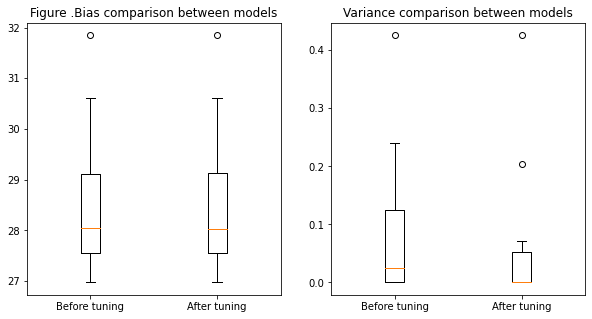

In [32]:
all_bias = [bias_2, bias_T]
all_variance= [var_2, var_T]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
xlabels = ['Before tuning', 'After tuning']

ax1.boxplot(all_bias, labels = xlabels);
ax1.title.set_text('Figure .Bias comparison between models');

ax2.boxplot(all_variance, labels = xlabels);
ax2.title.set_text('Variance comparison between models');

## 5. Testing and Discussion

In [33]:
S_Final = copy.deepcopy(S_Selected)
y = S_Final['Salary_Encoded']
S_Final, y0 = target_var(equiv,'a', S_Final)
S_Final, y1 = target_var(equiv1,'a', S_Final)
S_Final, y2 = target_var(equiv2,'a', S_Final)
S_Final, y3 = target_var(equiv3,'a', S_Final)
S_Final, y4 = target_var(equiv4,'a', S_Final)
S_Final, y5 = target_var(equiv5,'a', S_Final)
S_Final, y6 = target_var(equiv6,'a', S_Final)
S_Final, y7 = target_var(equiv7,'a', S_Final)
S_Final, y8 = target_var(equiv8,'a', S_Final)
S_Final, y9 = target_var(equiv9,'a', S_Final)
S_Final, y10 = target_var(equiv10,'a', S_Final)
S_Final, y11 = target_var(equiv11,'a', S_Final)
S_Final, y12 = target_var(equiv12,'a', S_Final)
S_Final, y13 = target_var(equiv13,'a', S_Final)

S_Final.drop(['Salary_Encoded'], axis = 1, inplace = True)
X = S_Final
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1, test_size = 0.3)
tr_idx = X_train.index.values
ts_idx = X_test.index.values

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)


y_tr, y_ts = y_train.values[train_idx], y_train.values[test_idx]
y_tr0, y_ts0 = y0.values[tr_idx], y0.values[ts_idx]
y_tr1, y_ts1 = y1.values[tr_idx], y1.values[ts_idx]
y_tr2, y_ts2 = y2.values[tr_idx], y2.values[ts_idx]
y_tr3, y_ts3 = y3.values[tr_idx], y3.values[ts_idx]
y_tr4, y_ts4 = y4.values[tr_idx], y4.values[ts_idx]
y_tr5, y_ts5 = y5.values[tr_idx], y5.values[ts_idx]
y_tr6, y_ts6 = y6.values[tr_idx], y6.values[ts_idx]
y_tr7, y_ts7 = y7.values[tr_idx], y7.values[ts_idx]
y_tr8, y_ts8 = y8.values[tr_idx], y8.values[ts_idx]
y_tr9, y_ts9 = y9.values[tr_idx], y9.values[ts_idx]
y_tr10, y_ts10 = y10.values[tr_idx], y10.values[ts_idx]
y_tr11, y_ts11 = y11.values[tr_idx], y11.values[ts_idx]
y_tr12, y_ts12 = y12.values[tr_idx], y12.values[ts_idx]
y_tr13, y_ts13 = y13.values[tr_idx], y13.values[ts_idx]

mm0_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm1_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm2_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm3_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm4_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm5_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm6_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm7_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm8_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm9_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm10_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm11_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm12_T = LogisticRegression(C= 0.01,solver = 'newton-cg')
mm13_T = LogisticRegression(C= 0.01,solver = 'newton-cg')

mm0_T.fit(X_train, y_tr0)
mm1_T.fit(X_train, y_tr1)
mm2_T.fit(X_train, y_tr2)
mm3_T.fit(X_train, y_tr3)
mm4_T.fit(X_train, y_tr4)
mm5_T.fit(X_train, y_tr5)
mm6_T.fit(X_train, y_tr6)
mm7_T.fit(X_train, y_tr7)
mm8_T.fit(X_train, y_tr8)
mm9_T.fit(X_train, y_tr9)
mm10_T.fit(X_train, y_tr10)
mm11_T.fit(X_train, y_tr11)
mm12_T.fit(X_train, y_tr12)
mm13_T.fit(X_train, y_tr13)

prob0 = mm0_T.predict_proba(X_test) 
prob1 = mm1_T.predict_proba(X_test)
prob2 = mm2_T.predict_proba(X_test)
prob3 = mm3_T.predict_proba(X_test)
prob4 = mm4_T.predict_proba(X_test)
prob5 = mm5_T.predict_proba(X_test)
prob6 = mm6_T.predict_proba(X_test)
prob7 = mm7_T.predict_proba(X_test)
prob8 = mm8_T.predict_proba(X_test)
prob9 = mm9_T.predict_proba(X_test)
prob10 = mm10_T.predict_proba(X_test)
prob11 = mm11_T.predict_proba(X_test)
prob12 = mm12_T.predict_proba(X_test)
prob13 = mm13_T.predict_proba(X_test)

yp0 = prob0[:,[0]]
yp1 = prob1[:,[0]] - prob0[:,[0]]
yp2 = prob2[:,[0]] - prob1[:,[0]]
yp3 = prob3[:,[0]] - prob2[:,[0]]
yp4 = prob4[:,[0]] - prob3[:,[0]]
yp5 = prob5[:,[0]] - prob4[:,[0]]
yp6 = prob6[:,[0]] - prob5[:,[0]]
yp7 = prob7[:,[0]] - prob6[:,[0]]
yp8 = prob8[:,[0]] - prob7[:,[0]]
yp9 = prob9[:,[0]] - prob8[:,[0]]
yp10 = prob10[:,[0]] - prob9[:,[0]]
yp11 = prob11[:,[0]] - prob10[:,[0]]
yp12 = prob12[:,[0]] - prob11[:,[0]]
yp13 = prob13[:,[0]] - prob12[:,[0]] 
yp14 = prob13[:,[1]]
yp = np.hstack((yp0, yp1, yp2, yp3, yp4, yp5, yp6, yp7, yp8, yp9, yp10, yp11, yp12, yp13, yp14))
y_pred = np.argmax(yp, axis=1)
ACC = accuracy_score(y_test,y_pred)* 100

print('Train Accuracy is: %.2f'%(Train_Acc), '%')
print('Test Accuracy is: %.2f' % (ACC),'%')


Train Accuracy is: 40.21 %
Test Accuracy is: 41.98 %


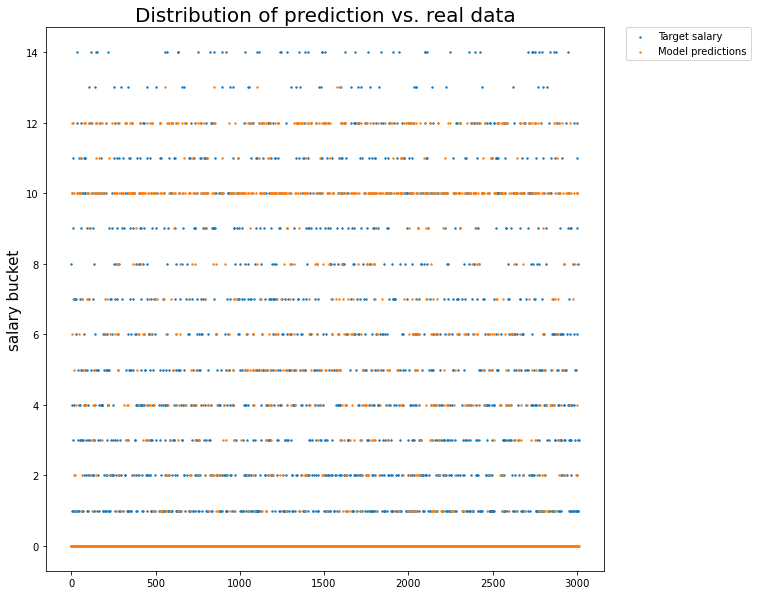

In [45]:
x = np.arange(0, len(y_pred),1)
plt.figure(figsize=(10,10))

plt.scatter(x, y_test, s=2, label ='Target salary')
plt.scatter(x, y_pred, s=2, label = 'Model predictions')

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0);
plt.title('Distribution of prediction vs. real data', size=20)
plt.ylabel('salary bucket', size=15);